In [2]:
import os, sys, glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import contextily as cx
import pickle

import IR_processing_utils
import IR_corrections

from tqdm import tqdm


plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 7


In [3]:
# Здесь нужно указать путь к директории с данными. Есть следующие варианты:
# 1) путь к папке непосредственно со снимками (tiff) для конкретной миссии
# 2) путь к папке, в которой несколько подпапок для разных версий конвертации jpg->tiff. В таком случае подпапка указыватся data_subdir.
# 3) путь к папке, в которой несколько папок DJI* для случая, когда одна миссия снималась в несколько заходов (с заменой аккумулятора) 

data_dir = r"M:\202507 Ingilor\Mavic3_IR\20250718_no4_Vol1a_shield"; flight_height = 300

# Имя подпапки с тифами (если подпаки нет, указать None). Актуально например при наличие разных версий конвертации jpg->tiff. 
#data_subdir = 'tiffs_thermal_parser, emis = 1.00'
data_subdir = None

sensor_size = [6.144, 7.68] #Mavic sensor size in mm

# Настройки алгоритма коррекции
corr_opts = {'detrend': True, 
             'use_L0': True,
             'L0_rad': 50,
             'L2_wnd': 9, 'L2_nsteps': 3,
             'L3_wnd': 9, 'L3_nsteps': 5,
             'L4_wnd': 5}

#***************************************************************************************************

opts_str = 'detrend=%d, use_L0=%d'%(corr_opts['detrend'],corr_opts['use_L0'])

dji_subdirs = glob.glob (data_dir + '\\DJI*')
dji_subdirs = [x for x in dji_subdirs if os.path.isdir(x)]

if len (dji_subdirs) == 0:
    dji_subdirs = [data_dir]


img_array = {}
for i, dji_subdir in enumerate (dji_subdirs):
    display(dji_subdir)
    if data_subdir is not None:
        data_dir_src = dji_subdir + '/' + data_subdir + '/'
    else:
        data_dir_src = dji_subdir + '/'

    cur_array, cur_df = IR_processing_utils.read_IR_images (data_dir_src, n_jobs = 1)
    #cur_df['folder'] = data_dir_src
    if i == 0:
        img_array['t_raw'] = cur_array
        img_df = cur_df
    else:
        img_array['t_raw'] = np.concatenate((img_array['t_raw'], cur_array), axis=2)
        img_df = pd.concat((img_df, cur_df), ignore_index = True)
    

img_shape = img_array['t_raw'].shape
img_N = img_df.shape[0]

img_df = IR_processing_utils.calc_azimuth4df (img_df)
img_df = IR_processing_utils.init_polygons4df (img_df, sensor_size, flight_height)

display(img_df.head())

pics_dir = data_dir + '/processing_pics' + (('_' + data_subdir) if data_subdir is not None else '') + '/'
if not os.path.isdir (pics_dir):
    os.mkdir (pics_dir)

save_dir = pics_dir + '/corr_with_L0_new/'
if not os.path.isdir (save_dir):
    os.mkdir (save_dir)







'M:\\202507 Ingilor\\Mavic3_IR\\20250718_no4_Vol1a_shield\\DJI_202507181955_263_Vol1andCtrlIR2'

,file,gps_lat,gps_lon,Image ImageWidth,Image ImageLength,Image BitsPerSample,Image Compression,Image PhotometricInterpretation,Image ImageDescription,Image Make,...,EXIF LensSpecification,folder,gps_azimuth,min_lon,max_lon,min_lat,max_lat,delta_lon,delta_lat,Polygon
0,DJI_20250718195818_0001_T.tiff,67.592620,66.979097,640.0,512.0,32.0,1.0,1.0,IronRed,DJI,...,9.1,M:\202507 Ingilor\Mavic3_IR\20250718_no4_Vol1a...,90.152006,66.976122,66.982072,67.591712,67.593528,0.00595,0.001816,"POLYGON ((66.98207210365399 67.59352804877274,..."
1,DJI_20250718195820_0002_T.tiff,67.592620,66.979262,640.0,512.0,32.0,1.0,1.0,IronRed,DJI,...,9.1,M:\202507 Ingilor\Mavic3_IR\20250718_no4_Vol1a...,90.123212,66.976287,66.982237,67.591712,67.593528,0.00595,0.001816,"POLYGON ((66.98223682585525 67.59352788210609,..."
2,DJI_20250718195823_0003_T.tiff,67.592619,66.979803,640.0,512.0,32.0,1.0,1.0,IronRed,DJI,...,9.1,M:\202507 Ingilor\Mavic3_IR\20250718_no4_Vol1a...,89.926610,66.976828,66.982778,67.591711,67.593527,0.00595,0.001816,"POLYGON ((66.98277790913268 67.5935274376617, ..."
3,DJI_20250718195826_0004_T.tiff,67.592620,66.980546,640.0,512.0,32.0,1.0,1.0,IronRed,DJI,...,9.1,M:\202507 Ingilor\Mavic3_IR\20250718_no4_Vol1a...,89.937695,66.977571,66.983521,67.591712,67.593528,0.00595,0.001816,"POLYGON ((66.98352096473366 67.59352779877277,..."
4,DJI_20250718195828_0005_T.tiff,67.592620,66.981423,640.0,512.0,32.0,1.0,1.0,IronRed,DJI,...,9.1,M:\202507 Ingilor\Mavic3_IR\20250718_no4_Vol1a...,89.973177,66.978448,66.984398,67.591712,67.593528,0.00595,0.001816,"POLYGON ((66.9843978258902 67.59352815988385, ..."


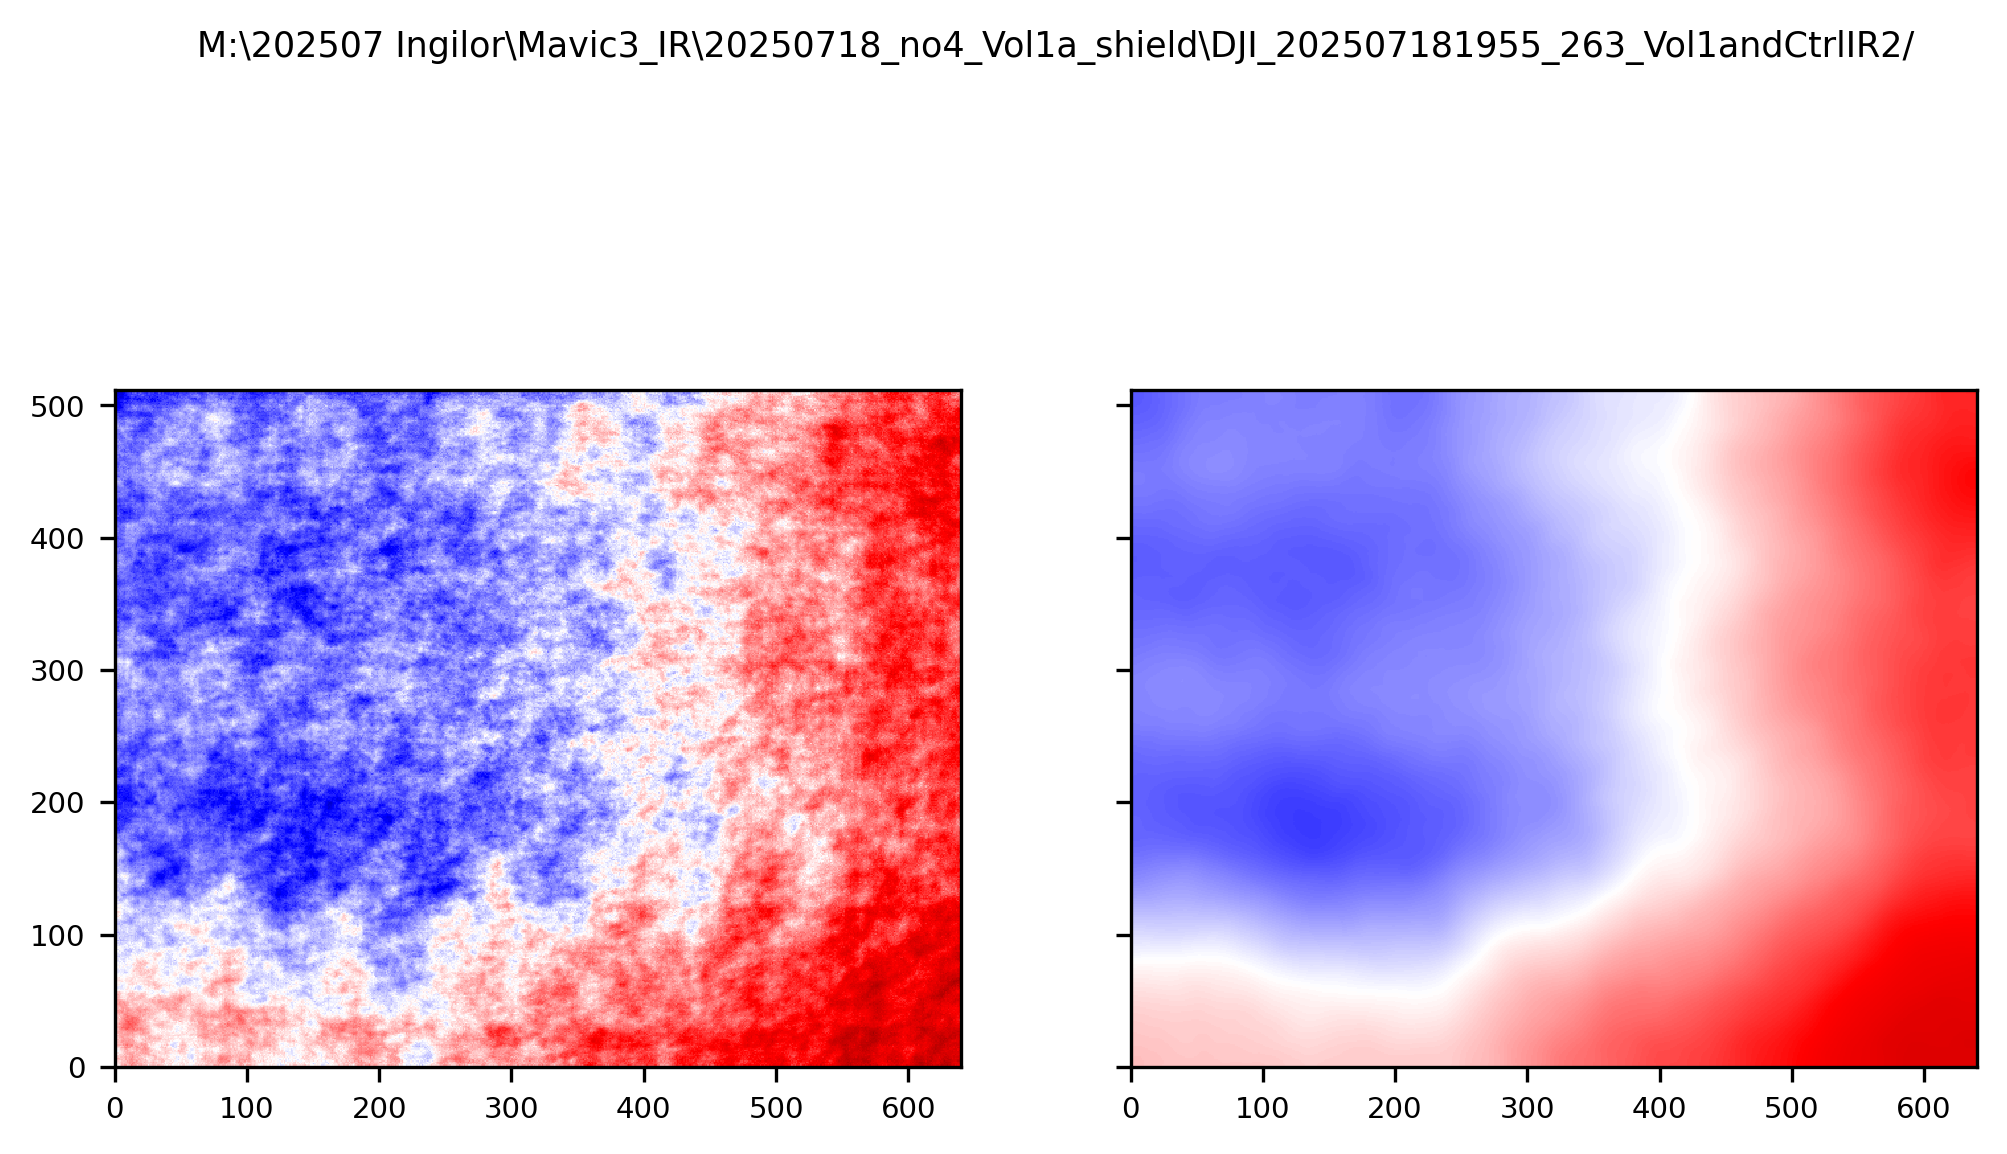

In [4]:
img_array['t0']  = IR_corrections.run_L0_corr (img_array['t_raw'], img_df, corr_opts['L0_rad'], save_dir)

In [6]:
diffs_poly_raw = np.zeros((img_array['t_raw'].shape[-1])) #*np.nan
diffs_SIFT_raw = np.zeros((img_array['t_raw'].shape[-1])) #*np.nan

diffs_poly_t0 = np.zeros((img_array['t_raw'].shape[-1])) #*np.nan
diffs_SIFT_t0 = np.zeros((img_array['t_raw'].shape[-1])) #*np.nan


for i in tqdm (range(2, img_array['t_raw'].shape[-1])):
    diffs_poly_raw[i], _ = IR_processing_utils.img_diff_poly(img_array['t_raw'], img_df, i, i-1)
    diffs_poly_t0[i], _  = IR_processing_utils.img_diff_poly(img_array['t0'],    img_df, i, i-1)

100%|██████████| 372/372 [00:55<00:00,  6.67it/s]


In [8]:
for i in tqdm (range(2, img_array['t_raw'].shape[-1])):
    diffs_SIFT_raw[i], _ = IR_processing_utils.img_diff_SIFT(img_array['t_raw'], img_df, i, i-1)
    diffs_SIFT_t0[i], _ = IR_processing_utils.img_diff_SIFT(img_array['t0'], img_df, i, i-1)

100%|██████████| 372/372 [02:07<00:00,  2.92it/s]


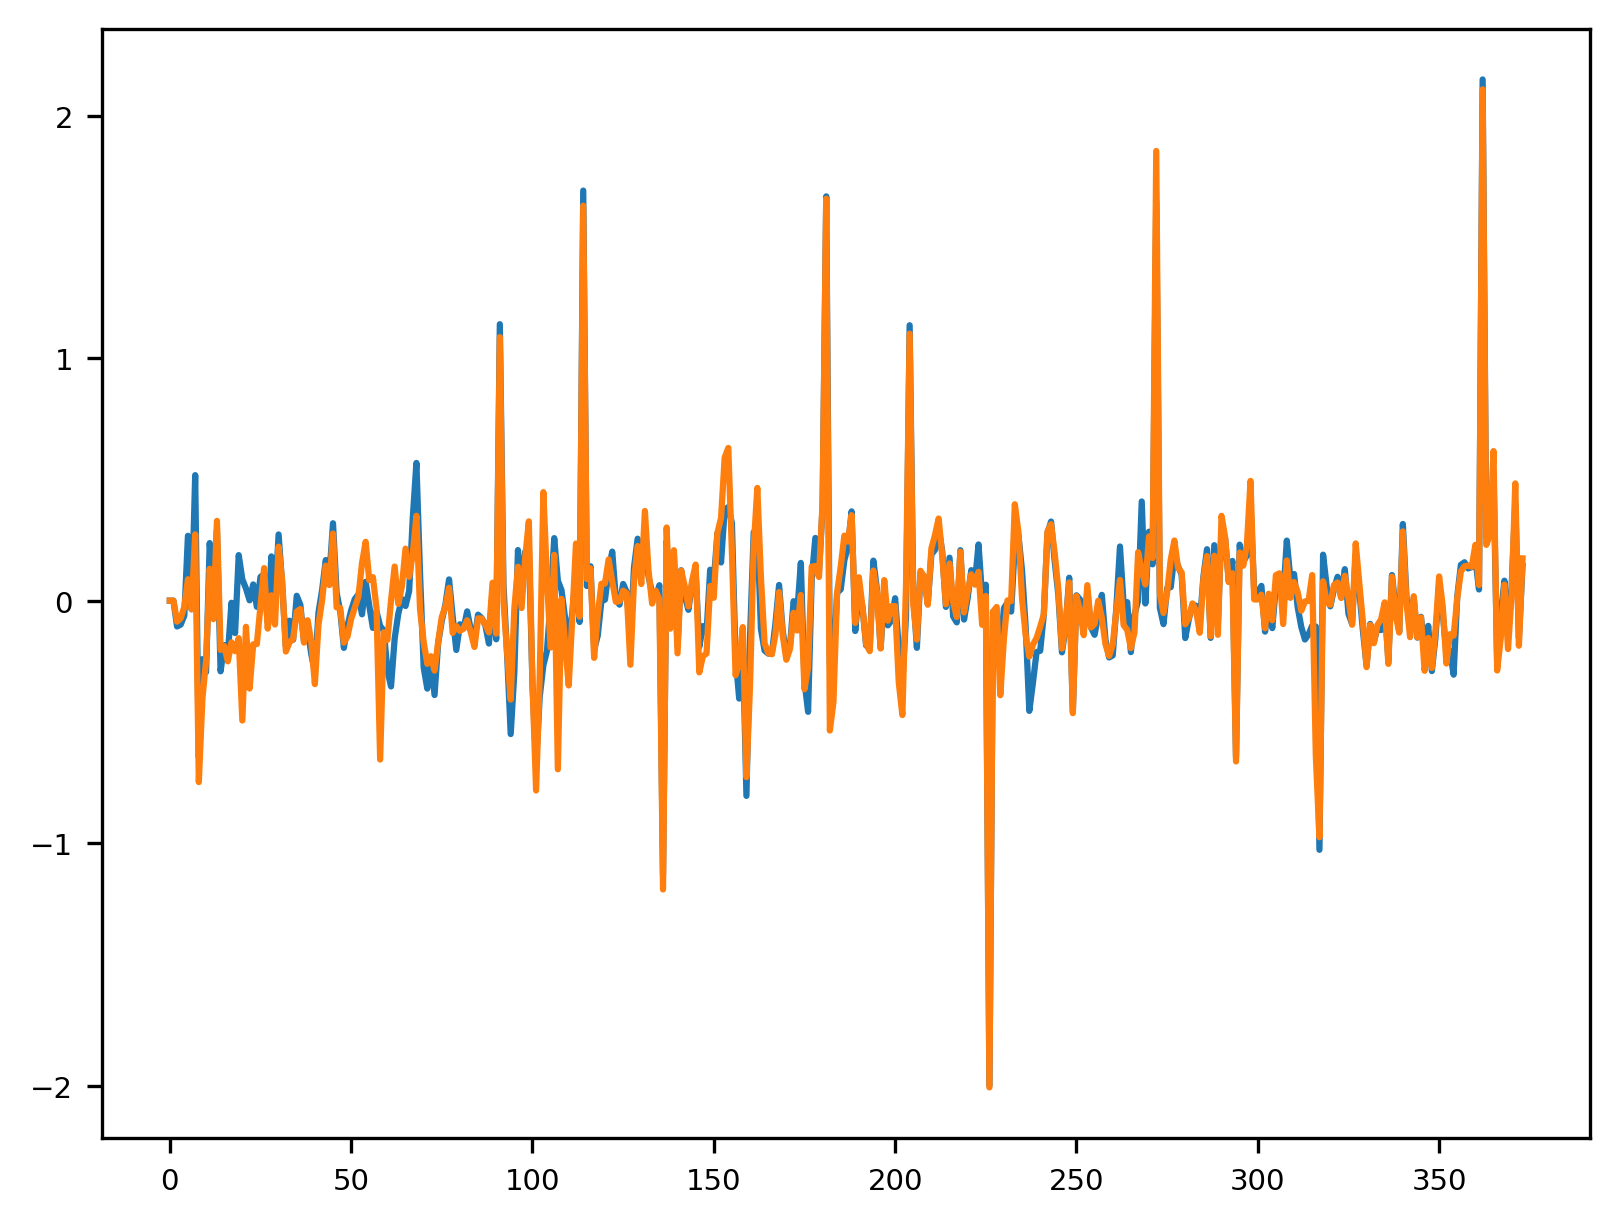

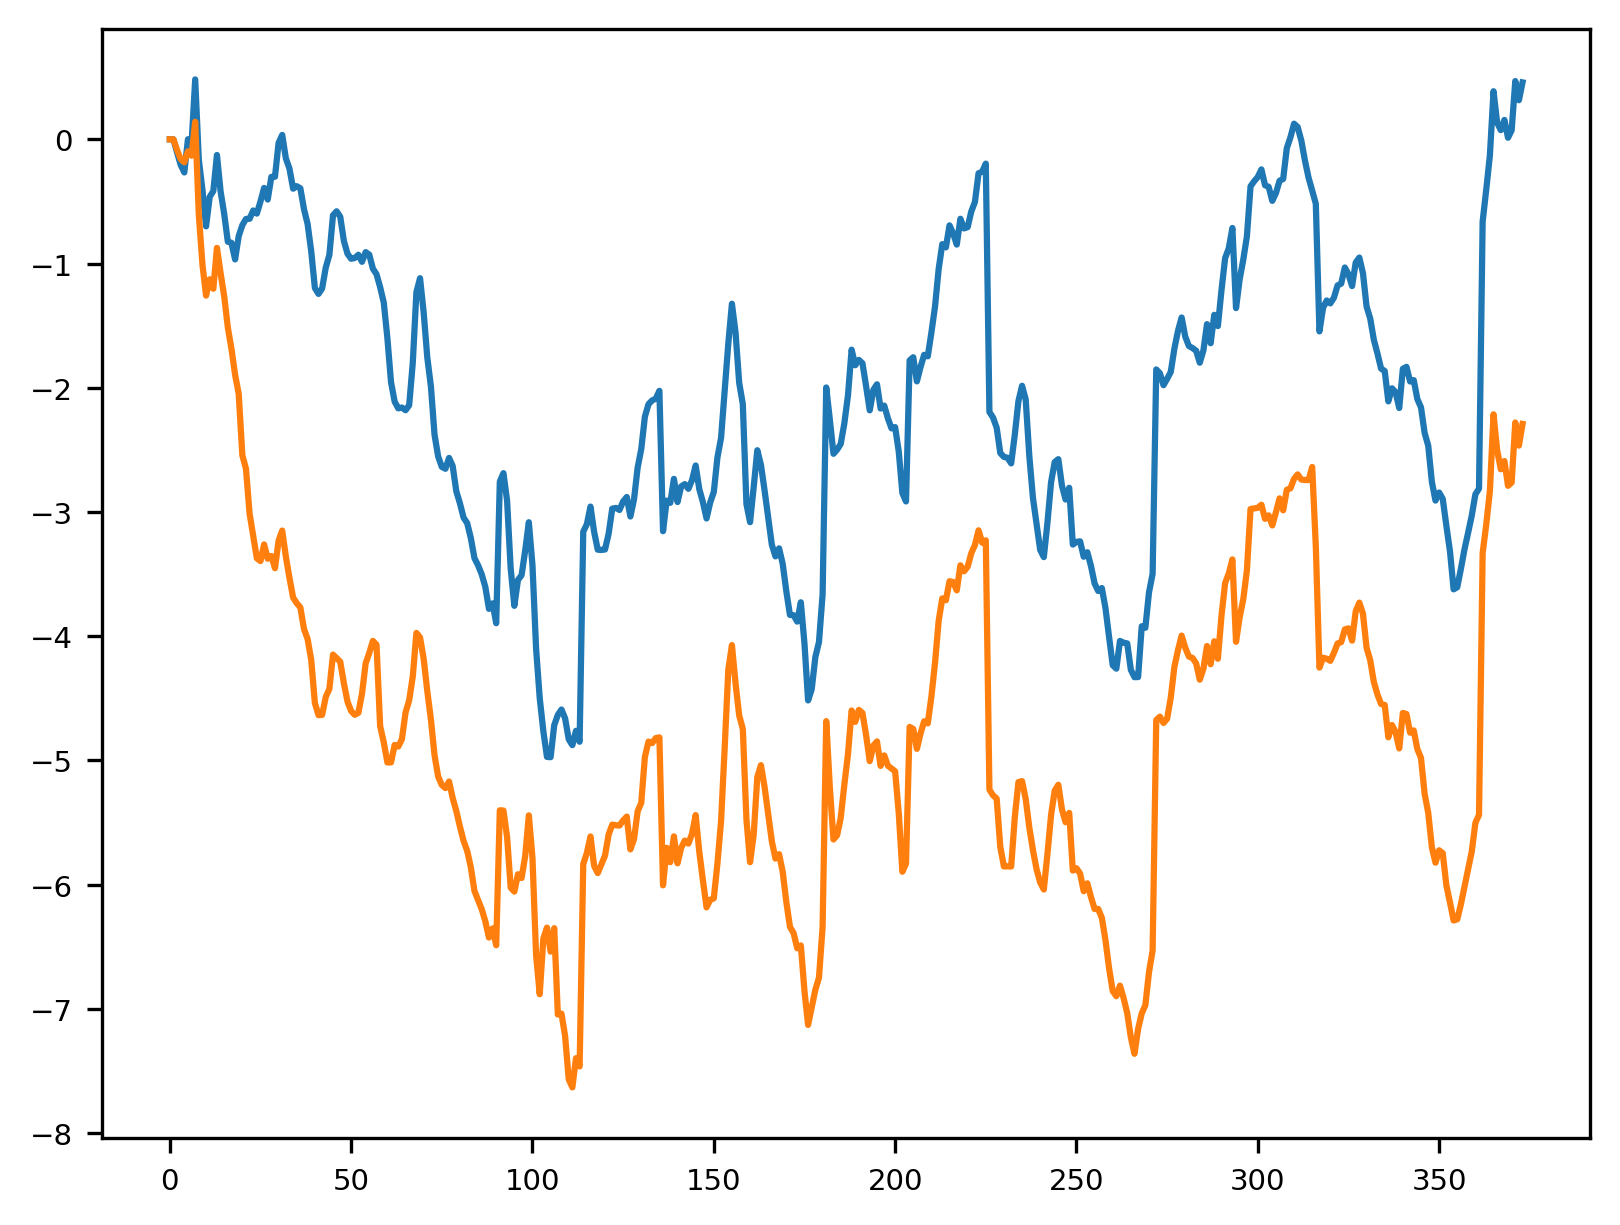

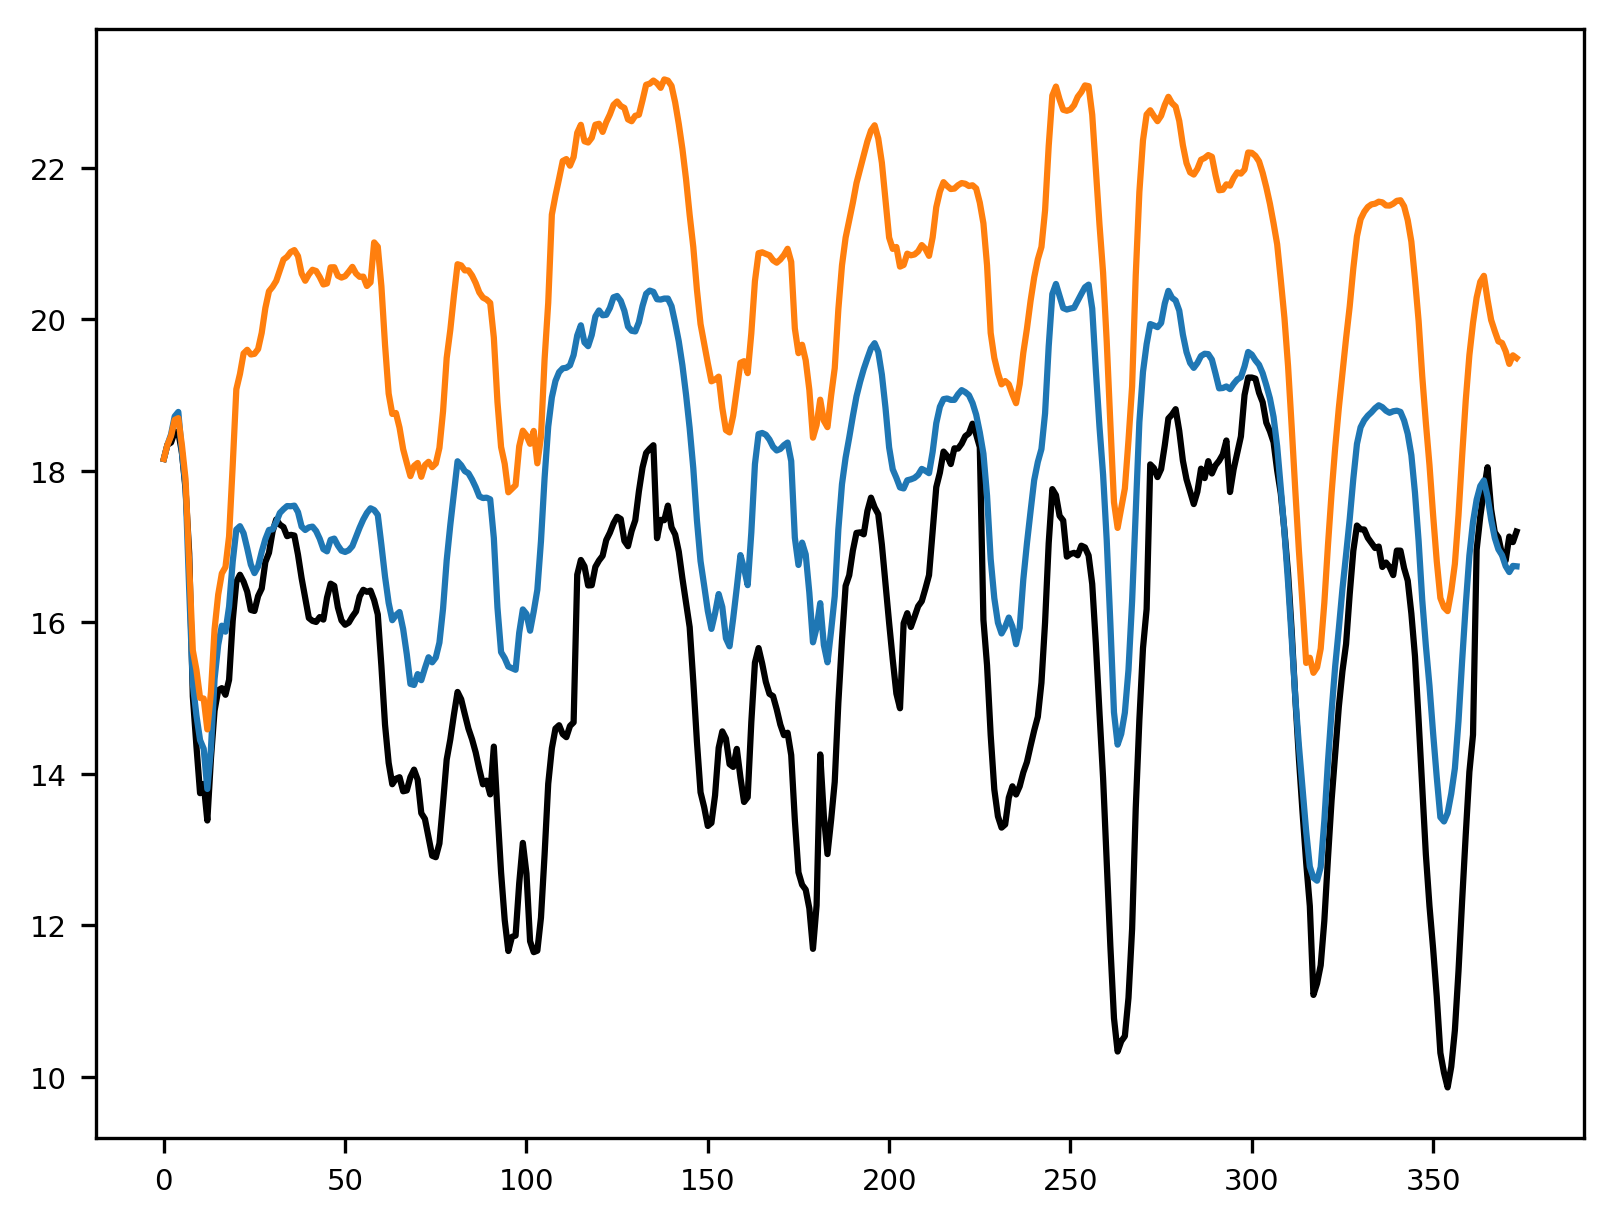

In [12]:
plt.figure()
#plt.plot(diffs_poly_raw)
plt.plot(diffs_poly_t0)

#plt.plot(diffs_SIFT_raw)
plt.plot(diffs_SIFT_t0)


plt.figure()
#plt.plot(diffs_poly_raw.cumsum())
plt.plot(diffs_poly_t0.cumsum())
#plt.plot(diffs_SIFT_raw.cumsum())
plt.plot(diffs_SIFT_t0.cumsum())

plt.figure()
plt.plot(img_array['t_raw'].mean(axis=0).mean(axis=0), '-k')
#plt.plot(img_array['t_raw'].mean(axis=0).mean(axis=0) - diffs_poly_raw.cumsum())
plt.plot(img_array['t_raw'].mean(axis=0).mean(axis=0) - diffs_poly_t0.cumsum())
#plt.plot(img_array['t_raw'].mean(axis=0).mean(axis=0) - diffs_SIFT_raw.cumsum())
plt.plot(img_array['t_raw'].mean(axis=0).mean(axis=0) - diffs_SIFT_t0.cumsum())


